In [1]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  #忽略烦人的警告
tf.logging.set_verbosity(tf.logging.ERROR)   #忽略烦人的警告
print(tf.__version__)
import numpy as np
from sklearn.decomposition import PCA

import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle   #对象存储用


from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
rfr = RandomForestClassifier(n_estimators=200, criterion='entropy')

dataroot_1 = "./UNSW-NB15 - CSV Files/a part of training and testing set/UNSW_NB15_training-set.csv"
dataroot_2 = "./UNSW-NB15 - CSV Files/a part of training and testing set/UNSW_NB15_testing-set.csv"

1.13.1


In [2]:
df_train_1 = pd.read_csv(dataroot_1,header=0,low_memory=False)  
df_train_2 = pd.read_csv(dataroot_2,header=0,low_memory=False)  
dataset = df_train_1.append([df_train_2])

In [3]:
print(dataset.shape)
print(dataset.columns)
print(dataset.values[0])
print(dataset.loc[:,'attack_cat'].value_counts())

(257673, 45)
Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')
[1 1.1e-05 'udp' '-' 'INT' 2 0 496 0 90909.0902 254 0 180363632.0 0.0 0 0
 0.011000000000000001 0.0 0.0 0.0 0 0 0 0 0.0 0.0 0.0 248 0 0 0 2 2 1 1 1
 2 0 0 0 1 2 0 'Normal' 0]
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
W

In [4]:
def filter_useless_feature(dataset):
    dataset = dataset.drop(['label'], axis=1)    #两个特征没用
    dataset = dataset.drop(['id'], axis=1)
    return dataset

def filter_labels(dataset):
    dataset['attack_cat'] = dataset['attack_cat'].apply(labels_map)
    return dataset

def labels_map(label):
    if(type(label) == int):      #已是数字，无需处理
        return label
    
    if label == 'Normal':
        return 0
    if label == 'Fuzzers':
        return 1
    if label == 'Analysis':
        return 2
    if label == 'Backdoor':
        return 3
    if label == 'DoS':
        return 4
    if label == 'Exploits':
        return 5
    if label == 'Generic':
        return 6
    if label == 'Reconnaissance':
        return 7
    if label == 'Shellcode':
        return 8
    if label == 'Worms':
        return 9
    return -1

def split_valid_from_train(train_dataset, valid_size):
    # Method 1
    train_dataset, valid_dataset, _, _ = train_test_split(train_dataset, train_dataset['attack_cat'], test_size=valid_size, random_state=None)
    # pandas中先重置index再打乱train. 否则只会调整各个行的顺序，而不会改变pandas的index
    # 重置
    train_dataset = train_dataset.reset_index(drop=True)
    # 打乱
    indexMask = np.arange(len(train_dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    train_dataset = train_dataset.iloc[indexMask]

    return train_dataset, valid_dataset

def labels_separate(dataset):
    y_ = dataset['attack_cat'].values
    temp = dataset
    temp.drop('attack_cat', axis=1, inplace=True)
    x_ = temp.values
    return x_, y_

def one_hot_process(dataset):
    # 独热编码 state
    state_dummies = pd.get_dummies(dataset['state'], prefix='state')
    dataset = pd.concat([dataset, state_dummies], axis=1)
    dataset = dataset.drop(['state'], axis=1)
    # 独热编码 proto
    proto_dummies = pd.get_dummies(dataset['proto'], prefix='proto')
    dataset = pd.concat([dataset, proto_dummies], axis=1)
    dataset = dataset.drop(['proto'], axis=1)
    # 独热编码 service     
    service_dummies = pd.get_dummies(dataset['service'], prefix='service')
    dataset = pd.concat([dataset, service_dummies], axis=1)
    dataset = dataset.drop(['service'], axis=1)
    return dataset
#归一化整个数据集，注意要存储归一化的参数x_avg,x_max,x_min以便后面真实环境预处理需要
def normalization(dataset):
    epsilon = 0.0001   #防止除数为0
    dataset = dataset.astype('float')
    target_features = ['dur','spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst'
    ]
    norm_params = pd.DataFrame(np.zeros([3, len(target_features)]), columns=target_features)  #存储归一化参数
    
    for feature in dataset.columns.values.tolist():    #对列（特征名）进行遍历
        if feature in target_features:
            x = dataset[feature]
            x_avg = dataset[feature].mean()
            x_max = np.max(dataset[feature])
            x_min = np.min(dataset[feature])

            norm_params[feature] = [x_avg, x_max, x_min]
            dataset[feature] = (x - x_min) / (x_max - x_min + epsilon)
    return dataset,norm_params
    
def combine_dataset(trainDF, testDF):
    all = pd.concat([trainDF, testDF], axis=0)
    return all, (trainDF.shape[0], testDF.shape[0])

def separate_dataset(comb, num_comb):  
    train_dataset_size , test_dataset_size = num_comb
    trainDF = comb.iloc[:train_dataset_size]
    testDF = comb.iloc[train_dataset_size: (train_dataset_size + test_dataset_size)]
    return trainDF, testDF

   
def data_process_full(trainDF, testDF):
    all, num_comb = combine_dataset(trainDF, testDF)
    all = one_hot_process(all)
    all,norm_params = normalization(all)
    trainDF,testDF = separate_dataset(all, num_comb)
    return trainDF,testDF,norm_params

In [5]:
dataset = filter_useless_feature(dataset)
dataset = filter_labels(dataset)

In [6]:
normal_df = dataset.loc[dataset['attack_cat'] == 0]
normal_df = normal_df.sample(n=90000,random_state=1, replace=False)
df_normal_train, df_normal_test = split_valid_from_train(normal_df, 0.2)

Fuzzers_df = dataset.loc[dataset['attack_cat'] == 1]
Fuzzers_df = Fuzzers_df.sample(n=24000,random_state=1, replace=False)
df_Fuzzers_train, df_Fuzzers_test = split_valid_from_train(Fuzzers_df, 0.2)

Analysis_df = dataset.loc[dataset['attack_cat'] == 2]
Analysis_df = Analysis_df.sample(n=2400,random_state=1, replace=False)
df_Analysis_train, df_Analysis_test = split_valid_from_train(Analysis_df, 0.2)

Backdoor_df = dataset.loc[dataset['attack_cat'] == 3]
Backdoor_df = Backdoor_df.sample(n=2000,random_state=1, replace=False)
df_Backdoor_train, df_Backdoor_test = split_valid_from_train(Backdoor_df, 0.2)

DoS_df = dataset.loc[dataset['attack_cat'] == 4]
DoS_df = DoS_df.sample(n=16000,random_state=1, replace=False)
df_DoS_train, df_DoS_test = split_valid_from_train(DoS_df, 0.2)

Exploits_df = dataset.loc[dataset['attack_cat'] == 5]
Exploits_df = Exploits_df.sample(n=40000,random_state=1, replace=False)
df_Exploits_train, df_Exploits_test = split_valid_from_train(Exploits_df, 0.2)

Generic_df = dataset.loc[dataset['attack_cat'] == 6]
Generic_df = Generic_df.sample(n=50000,random_state=1, replace=False)
df_Generic_train, df_Generic_test = split_valid_from_train(Generic_df, 0.2)

Reconnaissance_df = dataset.loc[dataset['attack_cat'] == 7]
Reconnaissance_df = Reconnaissance_df.sample(n=10000,random_state=1, replace=False)
df_Reconnaissance_train, df_Reconnaissance_test = split_valid_from_train(Reconnaissance_df, 0.2)

Shellcode_df = dataset.loc[dataset['attack_cat'] == 8]
Shellcode_df = Shellcode_df.sample(n=1500,random_state=1, replace=False)
df_Shellcode_train, df_Shellcode_test = split_valid_from_train(Shellcode_df, 0.2)

Worms_df = dataset.loc[dataset['attack_cat'] == 9]
Worms_df = Worms_df.sample(n=174,random_state=1, replace=False)
df_Worms_train, df_Worms_test = split_valid_from_train(Worms_df, 0.2)


In [7]:
#整合
df_train = df_normal_train.append([df_Fuzzers_train, df_Analysis_train, df_Backdoor_train, df_DoS_train, df_Exploits_train, df_Generic_train, df_Reconnaissance_train, df_Shellcode_train, df_Worms_train])
df_test = df_normal_test.append([df_Fuzzers_test, df_Analysis_test, df_Backdoor_test, df_DoS_test, df_Exploits_test, df_Generic_test, df_Reconnaissance_test, df_Shellcode_test, df_Worms_test])


In [8]:
#独热编码和正则化
df_train, df_test, norm_params = data_process_full(
    df_train, df_test
)

In [9]:
print(df_train.shape)
print(df_train.loc[:,'attack_cat'].value_counts())

(188859, 197)
0.0    72000
6.0    40000
5.0    32000
1.0    19200
4.0    12800
7.0     8000
2.0     1920
3.0     1600
8.0     1200
9.0      139
Name: attack_cat, dtype: int64


In [10]:
print(df_train.columns.tolist())

['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'state_ACC', 'state_CLO', 'state_CON', 'state_ECO', 'state_FIN', 'state_INT', 'state_PAR', 'state_REQ', 'state_RST', 'state_URN', 'state_no', 'proto_3pc', 'proto_a/n', 'proto_aes-sp3-d', 'proto_any', 'proto_argus', 'proto_aris', 'proto_arp', 'proto_ax.25', 'proto_bbn-rcc', 'proto_bna', 'proto_br-sat-mon', 'proto_cbt', 'proto_cftp', 'proto_chaos', 'proto_compaq-peer', 'proto_cphb', 'proto_cpnx', 'proto_crtp', 'proto_crudp', 'proto_dcn', 'proto_ddp', 'proto_ddx', 'proto_dgp', 'proto_egp', 'proto_eigrp', 'proto_emcon', 'prot

In [14]:
str0 = ""
for item in df_train.columns.tolist():
    str0 += item + ', '
str0.replace("_", "\_", 1000)

print(str0.replace("_", "\_", 1000))

dur, spkts, dpkts, sbytes, dbytes, rate, sttl, dttl, sload, dload, sloss, dloss, sinpkt, dinpkt, sjit, djit, swin, stcpb, dtcpb, dwin, tcprtt, synack, ackdat, smean, dmean, trans\_depth, response\_body\_len, ct\_srv\_src, ct\_state\_ttl, ct\_dst\_ltm, ct\_src\_dport\_ltm, ct\_dst\_sport\_ltm, ct\_dst\_src\_ltm, is\_ftp\_login, ct\_ftp\_cmd, ct\_flw\_http\_mthd, ct\_src\_ltm, ct\_srv\_dst, is\_sm\_ips\_ports, attack\_cat, state\_ACC, state\_CLO, state\_CON, state\_ECO, state\_FIN, state\_INT, state\_PAR, state\_REQ, state\_RST, state\_URN, state\_no, proto\_3pc, proto\_a/n, proto\_aes-sp3-d, proto\_any, proto\_argus, proto\_aris, proto\_arp, proto\_ax.25, proto\_bbn-rcc, proto\_bna, proto\_br-sat-mon, proto\_cbt, proto\_cftp, proto\_chaos, proto\_compaq-peer, proto\_cphb, proto\_cpnx, proto\_crtp, proto\_crudp, proto\_dcn, proto\_ddp, proto\_ddx, proto\_dgp, proto\_egp, proto\_eigrp, proto\_emcon, proto\_encap, proto\_etherip, proto\_fc, proto\_fire, proto\_ggp, proto\_gmtp, proto\_gre,

In [11]:
#分离标签
df_train_X, df_train_y = labels_separate(df_train)

In [12]:
df_train_y = df_train_y.astype('int')

In [13]:
#带交叉验证的RFE
rfecv = RFECV(estimator=rfr, cv=StratifiedKFold(n_splits=2, random_state=1),
              scoring='accuracy')
rfecv.fit(df_train_X, df_train_y)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=False),
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

In [14]:
print(rfecv.n_features_)
print(rfecv.ranking_)
# 选取特征
index = 0
features_selected = []
for item in rfecv.ranking_:
    if(item == 1):
        features_selected.append(df_train.columns.values.tolist()[index])
    index+=1
print(features_selected)

26
[  1   6   1   1   1   1   1   1   1   1   1   3   1   2   1   4  12   9
   8  26   1   1   1   1   1  17  13   1   1  10   1   1   1  38  41  15
   7   1  18 166 167  19 164  21   5 169  23 165 168 171  76 136 128  34
 141 147  20  93  81  57 145 162 137 156 127  59  95  63  42  82  98  96
 130 105  60 111 124 138  69 148 161 101  31 132  78  67 129 163  56  97
  70 121  29 116 119 113  77 144  51 142 154 135  32  53  43 131  83  80
  52  88 110  94  84 120  92  50 107  75  55  54  86  33 150 159 112 140
 109  65  24  74  64  49 134  73  66 102 146  87 100 126  40 170 155  47
  91 103 152  22 117  58  30  62 123  68  44  61  90  48 157 104  39  36
  85  14 114 133  72 125  79   1  16  71 118 122  45 139  99  46 115 151
  89 108 143   1  35   1  28  25  11 153 106 158  27  37 160 149]
['dur', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'sinpkt', 'sjit', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'ct_srv_src', 'ct_state_ttl', 'ct_src_dport_ltm

Optimal number of features : 26
Ranking of features : [  1   6   1   1   1   1   1   1   1   1   1   3   1   2   1   4  12   9
   8  26   1   1   1   1   1  17  13   1   1  10   1   1   1  38  41  15
   7   1  18 166 167  19 164  21   5 169  23 165 168 171  76 136 128  34
 141 147  20  93  81  57 145 162 137 156 127  59  95  63  42  82  98  96
 130 105  60 111 124 138  69 148 161 101  31 132  78  67 129 163  56  97
  70 121  29 116 119 113  77 144  51 142 154 135  32  53  43 131  83  80
  52  88 110  94  84 120  92  50 107  75  55  54  86  33 150 159 112 140
 109  65  24  74  64  49 134  73  66 102 146  87 100 126  40 170 155  47
  91 103 152  22 117  58  30  62 123  68  44  61  90  48 157 104  39  36
  85  14 114 133  72 125  79   1  16  71 118 122  45 139  99  46 115 151
  89 108 143   1  35   1  28  25  11 153 106 158  27  37 160 149]


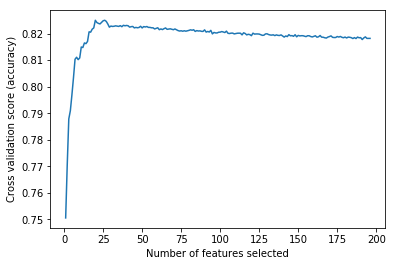

In [25]:
#import matplotlib.pyplot as plt
print("Optimal number of features : %d" % rfecv.n_features_)
print("Ranking of features : %s" % rfecv.ranking_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.savefig("./rfe_version_one.eps",format="eps")
plt.show()

In [16]:
# from sklearn.feature_selection import RFE
# rfe = RFE(estimator=rfr, n_features_to_select=16)
# rfe.fit(df_train_X, df_train_y)
# # 选取特征
# index = 0
# features_selected = []
# for item in rfe.ranking_:
#     if(item == 1):
#         features_selected.append(df_train.columns.values.tolist()[index])
#     index+=1
# print(features_selected)

['sbytes', 'dbytes', 'rate', 'sttl', 'sload', 'dload', 'tcprtt', 'smean', 'dmean', 'ct_state_ttl', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_srv_dst', 'proto_udp', 'service_dns']
